In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve




In [132]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Quora_database.db',echo=False)

In [133]:
df = pd.read_csv("../input/train.csv")

In [134]:
#Write records stored in a DataFrame df to a SQL database.
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html

df.to_sql("Quora_data", con=engine, if_exists='append', index=False)

In [135]:
res = engine.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name)

('Quora_data',)


In [136]:
#Considering less number of data point like ~100k
Total_data = pd.read_sql_query(""" SELECT * From Quora_data ORDER BY RANDOM() LIMIT 100000""", engine) 

In [137]:
Total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


In [138]:
#Checking whether there are any rows with null values
nan_rows = Total_data[Total_data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [139]:
Total_data = Total_data.dropna()

In [140]:
nan_rows = Total_data[Total_data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [141]:
#checking whether there are any repeated pair of questions

pair_duplicates = Total_data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - Total_data.shape[0])

Number of duplicate questions -8842


In [142]:
#Deduplication of entries
data = Total_data.drop_duplicates(subset={'qid1','qid2','is_duplicate'}, keep='first', inplace=False)
data.shape

(91158, 6)

**PREPROCESSING**

In [143]:
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

In [144]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

## Basic Feature

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [145]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len() 
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))

In [146]:
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
data['word_share'] = data.apply(normalized_word_share, axis=1)

data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']- data['freq_qid2'])

#df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

In [147]:
data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,203019,305508,305509,Is Facebook recording the video chats?,What are the little rings on Facebooks video c...,0,1,1,38,50,6,9,2.0,15.0,0.133333,2,0
1,44290,79515,79516,What is the difference between low and high gr...,What is the difference between an hydroelectri...,0,1,1,57,66,10,11,6.0,21.0,0.285714,2,0
2,149447,235401,235402,Is there gold in Virginia?,Is there any gold mines in Virginia?,1,1,1,26,36,5,7,5.0,12.0,0.416667,2,0


## Advance Feature

** Advanced Feature Extraction (NLP and Fuzzy Features) **

***Definition:***

Token: You get a token by splitting sentence a space
Stop_Word : stop words as per NLTK.
Word : A token that is not a stop_word

***Features:***

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 

cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 

csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 

csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 

ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 


ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 


last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 


first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 


abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 


mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2 


fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [148]:
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [149]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [150]:
data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,203019,305508,305509,Is Facebook recording the video chats?,What are the little rings on Facebooks video c...,0,1,1,38,50,6,9,2.0,15.0,0.133333,2,0
1,44290,79515,79516,What is the difference between low and high gr...,What is the difference between an hydroelectri...,0,1,1,57,66,10,11,6.0,21.0,0.285714,2,0
2,149447,235401,235402,Is there gold in Virginia?,Is there any gold mines in Virginia?,1,1,1,26,36,5,7,5.0,12.0,0.416667,2,0


In [151]:
data = extract_features(data)

token features...
fuzzy features..


In [152]:
data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,203019,305508,305509,is facebook recording the video chats,what are the little rings on facebooks video c...,0,1,1,38,50,6,9,2.0,15.0,0.133333,2,0,0.249994,0.199996,0.499975,0.249994,0.333328,0.222220,0,0,3,7.5,72,72,51,61,0.282051
1,44290,79515,79516,what is the difference between low and high gr...,what is the difference between an hydroelectri...,0,1,1,57,66,10,11,6.0,21.0,0.285714,2,0,0.249994,0.199996,0.999980,0.714276,0.599994,0.545450,0,1,1,10.5,76,69,68,74,0.534483
2,149447,235401,235402,is there gold in virginia,is there any gold mines in virginia,1,1,1,26,36,5,7,5.0,12.0,0.416667,2,0,0.999950,0.666644,0.999967,0.749981,0.999980,0.714276,1,1,2,6.0,100,83,83,73,0.481481


In [153]:
data.shape

(91158, 32)

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91158 entries, 0 to 99999
Data columns (total 32 columns):
id                      91158 non-null int64
qid1                    91158 non-null int64
qid2                    91158 non-null int64
question1               91158 non-null object
question2               91158 non-null object
is_duplicate            91158 non-null int64
freq_qid1               91158 non-null int64
freq_qid2               91158 non-null int64
q1len                   91158 non-null int64
q2len                   91158 non-null int64
q1_n_words              91158 non-null int64
q2_n_words              91158 non-null int64
word_Common             91158 non-null float64
word_Total              91158 non-null float64
word_share              91158 non-null float64
freq_q1+q2              91158 non-null int64
freq_q1-q2              91158 non-null int64
cwc_min                 91158 non-null float64
cwc_max                 91158 non-null float64
csc_min                 

### remove empty question rows 

> If you got any then try this  :
> data.drop(data.loc[data['id']== idNumber].index, inplace=True)

In [155]:
a=0
for qu1 in list(data['question1']):
    if len(list(qu1))==0:
        print(data[data['question1']== qu1])
        a+=1 
print(a)

0


In [156]:
a=0
for qu2 in list(data['question2']):
    if len(list(qu2))==0:
        print(data[data['question2']== qu2])
        a+=1 
print(a)

0


In [157]:
data['is_duplicate'].value_counts()

0    57652
1    33506
Name: is_duplicate, dtype: int64

In [158]:
#Checking to see how much % of data still remains
(data['id'].size*1.0)/(Total_data['id'].size*1.0)*100

91.158

In [159]:
data.shape

(91158, 32)

In [160]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,203019,305508,305509,is facebook recording the video chats,what are the little rings on facebooks video c...,0,1,1,38,50,6,9,2.0,15.0,0.133333,2,0,0.249994,0.199996,0.499975,0.249994,0.333328,0.222220,0,0,3,7.5,72,72,51,61,0.282051
1,44290,79515,79516,what is the difference between low and high gr...,what is the difference between an hydroelectri...,0,1,1,57,66,10,11,6.0,21.0,0.285714,2,0,0.249994,0.199996,0.999980,0.714276,0.599994,0.545450,0,1,1,10.5,76,69,68,74,0.534483
2,149447,235401,235402,is there gold in virginia,is there any gold mines in virginia,1,1,1,26,36,5,7,5.0,12.0,0.416667,2,0,0.999950,0.666644,0.999967,0.749981,0.999980,0.714276,1,1,2,6.0,100,83,83,73,0.481481
3,140953,55378,197573,why does keyboard letters are not arranged in ...,why are not the letters on the keyboard in alp...,1,1,1,63,61,10,10,5.0,19.0,0.263158,2,0,0.749981,0.599988,0.799984,0.666656,0.699993,0.636358,1,1,1,10.5,87,80,68,68,0.238095
4,197314,298235,298236,how do i know for sure if i am falling out of ...,how do i know if i am falling in love,0,1,1,50,37,12,9,8.0,21.0,0.380952,2,0,0.999967,0.749981,0.833319,0.624992,0.799992,0.615380,1,1,3,11.5,96,78,80,76,0.435897


**Random train test split( 70:30)**

In [161]:
Total_Y = data['is_duplicate'].values
Total_X = data.drop(['is_duplicate'],axis=1)

In [162]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(Total_X, Total_Y, test_size=0.33)

In [163]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (61075, 31)
Number of data points in test data : (30083, 31)


In [164]:
print(f"Train Data : ({len(X_train)} , {len(y_train)})")
print(f"Test Data : ({len(X_test)} , {len( y_test)})")

Train Data : (61075 , 61075)
Test Data : (30083 , 30083)


## Trying out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
question_1 = list(X_train['question1'])
question_2 = list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf_2 = TfidfVectorizer(lowercase=False, )
word2tfidf_1 = tfidf.fit_transform(question_1)
word2tfidf_2 = tfidf_2.fit_transform(question_2)

# dict key:word and value:tf-idf score
#word2tfidf_1 = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print(word2tfidf_1.shape, y_train.shape)
print(word2tfidf_2.shape, y_train.shape)

(61075, 29279) (61075,)
(61075, 27197) (61075,)


In [166]:
question_test_1 = list(X_test['question1'])
question_test_2 = list(X_test['question2'])


word2tfidf_test_1 = tfidf.transform(question_test_1)
word2tfidf_test_2 = tfidf_2.transform(question_test_2)

# dict key:word and value:tf-idf score
#word2tfidf_1 = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print(word2tfidf_test_1.shape, y_test.shape)
print(word2tfidf_test_2.shape, y_test.shape)

(30083, 29279) (30083,)
(30083, 27197) (30083,)


In [167]:
from scipy.sparse import hstack

word2tfidf = hstack((word2tfidf_1, word2tfidf_2)) # stacking the sparse matrices
word2tfidf_test = hstack((word2tfidf_test_1, word2tfidf_test_2))

In [168]:
#make a fresh dataframe with obtained features
New_data = X_train.drop(['qid1','qid2', 'id','question1','question2'], axis=1)
New_test_data = X_test.drop(['qid1','qid2', 'id','question1','question2'], axis=1)

In [169]:
X_train= hstack((word2tfidf, New_data))

In [170]:
X_test= hstack((word2tfidf_test, New_test_data))

In [171]:
X_train

<61075x56502 sparse matrix of type '<class 'numpy.float64'>'
	with 2655350 stored elements in COOrdinate format>

In [172]:
X_test

<30083x56502 sparse matrix of type '<class 'numpy.float64'>'
	with 1295550 stored elements in COOrdinate format>

## Building a random model (Finding worst-case log-loss) 

In [173]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

> **I am using a random model to get the upper bound for the log-loss. I want the value of log-loss to be lesser than the log-loss of a random model.**

In [174]:
test_len = len(y_test)

Log loss on Test Data using Random Model 0.887019447220453


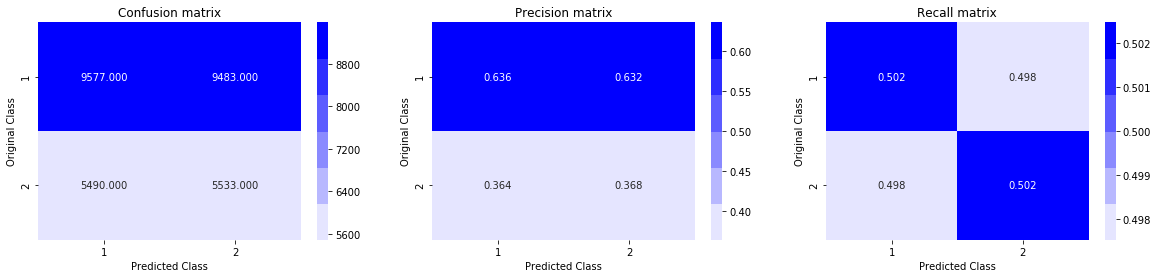

In [175]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter tuning

** The reason, why I'm choosing Logistic regression first on top of it is, LR works more significant on a higer dimention. **

> **CalibratedCV is used to get probabilities of each output label. Using Logistic regression, we only get the output labels but not the probabilities. We are using log-loss as the performance metric, which requires probabilities.**

In [176]:
from tqdm import tqdm_notebook as tqdm

In [177]:
import warnings
warnings.filterwarnings("ignore")

For values of alpha =  1e-05 The log loss is: 0.4507473026142392
For values of alpha =  0.0001 The log loss is: 0.4382909751666378
For values of alpha =  0.001 The log loss is: 0.4557911831516765
For values of alpha =  0.01 The log loss is: 0.48728316713305553
For values of alpha =  0.1 The log loss is: 0.5086345160082415
For values of alpha =  1 The log loss is: 0.5386223875583642
For values of alpha =  10 The log loss is: 0.5856169285260584



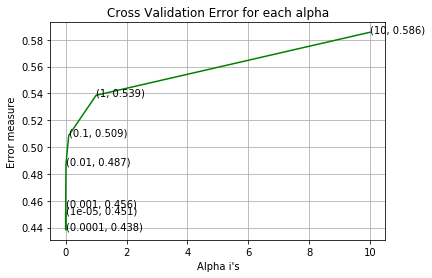

For values of best alpha =  0.0001 The train log loss is: 0.4343122150745893
For values of best alpha =  0.0001 The test log loss is: 0.4382909751666378
Total number of data points : 30083


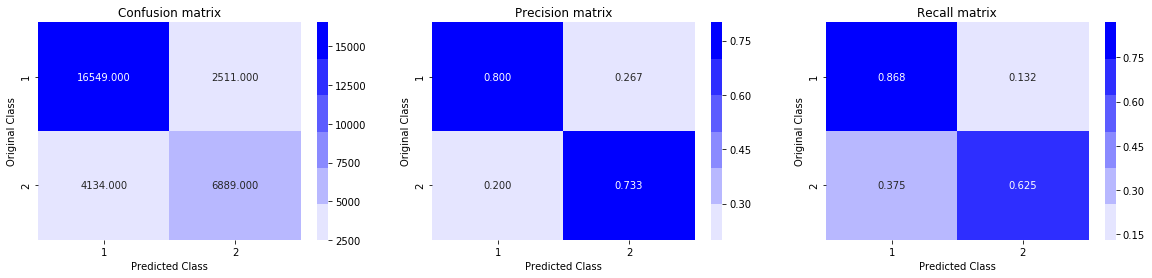

In [178]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

OBSERVATIOIN: 
* With alpha value = 1e-05 I got a train loss of 0.434 and a test loss of 0.438. These two values are being very close, shows that my model is not overfit. But I have to try other models also.

## Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.46263680304083377
For values of alpha =  0.0001 The log loss is: 0.47772042666498665
For values of alpha =  0.001 The log loss is: 0.5412904284912025
For values of alpha =  0.01 The log loss is: 0.5410999766014124
For values of alpha =  0.1 The log loss is: 0.5256468197291836
For values of alpha =  1 The log loss is: 0.6369449337221107
For values of alpha =  10 The log loss is: 0.6452726260478437



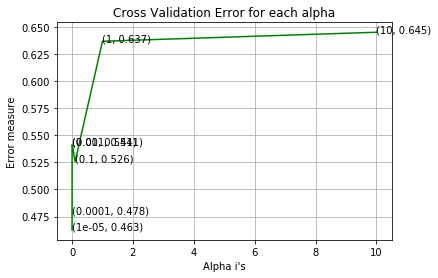

For values of best alpha =  1e-05 The train log loss is: 0.461562430258912
For values of best alpha =  1e-05 The test log loss is: 0.46263680304083377
Total number of data points : 30083


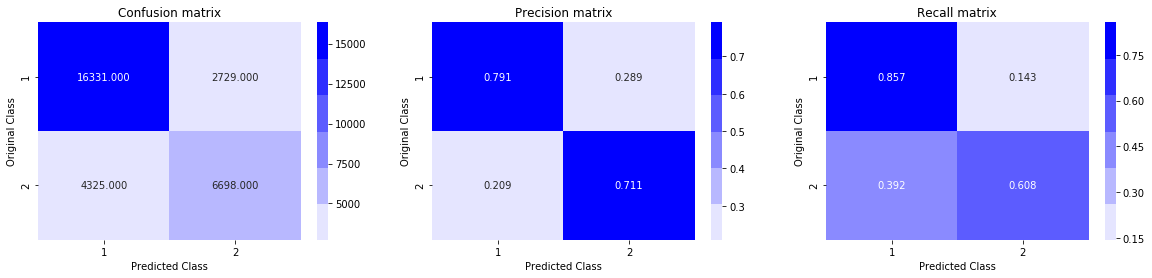

In [179]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

OBSERVATIOIN: 
* With alpha value = 1e-05 I got a train loss of 0.471 and a test loss of 0.476. These two values are being very close, shows that my model is not overfit. 

## Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [180]:
import time

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

clf = xgb.XGBClassifier(objective= 'binary:logistic',eval_metric='logloss')

param_grid = {'max_depth' : [2,3,4,5],'n_estimators' : [100,200,300,400,500,600,700],'learning_rate' : [0.1,1]}

#fit_params = {'objective': 'binary:logistic','eval_metric': 'logloss'}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, cv=2,
                            scoring='neg_log_loss')
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in tqdm(sorted(best_params.keys())):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Randomized search time: 3891.2928891181946
Best score: -0.36233881817119346
Best params: 


learning_rate: 0.1
max_depth: 5
n_estimators: 700



In [184]:
X_train.shape

(61075, 56502)

In [185]:
X_test.shape

(30083, 56502)

In [182]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['n_estimators'] = 700
params['max_depth'] = 5
params['learning_rate'] = 0.1


d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

[0]	train-logloss:0.654704	valid-logloss:0.654707
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.475861	valid-logloss:0.477874
[20]	train-logloss:0.423575	valid-logloss:0.427828
[30]	train-logloss:0.402053	valid-logloss:0.408079
[40]	train-logloss:0.390903	valid-logloss:0.398764
[50]	train-logloss:0.383257	valid-logloss:0.392384
[60]	train-logloss:0.377672	valid-logloss:0.388441
[70]	train-logloss:0.372836	valid-logloss:0.385153
[80]	train-logloss:0.368404	valid-logloss:0.382298
[90]	train-logloss:0.364222	valid-logloss:0.379651
[100]	train-logloss:0.360851	valid-logloss:0.377674
[110]	train-logloss:0.358094	valid-logloss:0.376026
[120]	train-logloss:0.355298	valid-logloss:0.374727
[130]	train-logloss:0.352675	valid-logloss:0.373353
[140]	train-logloss:0.350365	valid-logloss:0.372259
[150]	train-logloss:0.348651	valid-logloss:0.37156
[160]	train-logloss:0.346303	

Total number of data points : 30083


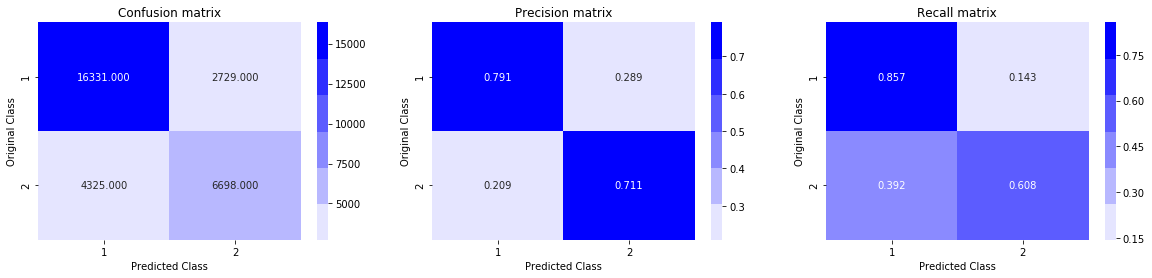

In [183]:
#predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [187]:
from prettytable import PrettyTable

In [188]:
x = PrettyTable(["Model",  "Train-logloss", "Test-log loss"])



x.add_row(["Logistic Regression" , 0.434,0.438])
x.add_row(["SVM" , 0.461,0.462])
x.add_row(["XGB" , 0.358837,  0.358840])

print(x)


+---------------------+---------------+---------------+
|        Model        | Train-logloss | Test-log loss |
+---------------------+---------------+---------------+
| Logistic Regression |     0.434     |     0.438     |
|         SVM         |     0.461     |     0.462     |
|         XGB         |    0.358837   |    0.35884    |
+---------------------+---------------+---------------+


**XgBoost done it's work very well. With the accepted hyperparameter from Random search hyperparamerter tunning, it has given test log-loss of 0.358.**

Here is the step by step guide of how I come to the end of this Quora Question Pair Case Study. 

Quora is the place where questions get answers. This website helps online users raise queries for knowing the unknown and reply to ones they are good at answering. 
There are 7.6 billion people living on the planet and over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

### About the problem 

 Quora has given an (almost) real-world dataset of question pairs, with the label of is_duplicate along with every question pair. The objective was to minimize the logloss of predictions on duplicacy in the testing dataset. Given a pair of questions q1 and q2, train a model that learns the function:
 
 f(q1, q2) → 0 or 1 
 
where 1 represents that q1 and q2 have the same intent and 0 otherwise.


###  Problem Statement 
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 



### Real world/Business Objectives and Constraints 

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

### Data Overview

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>
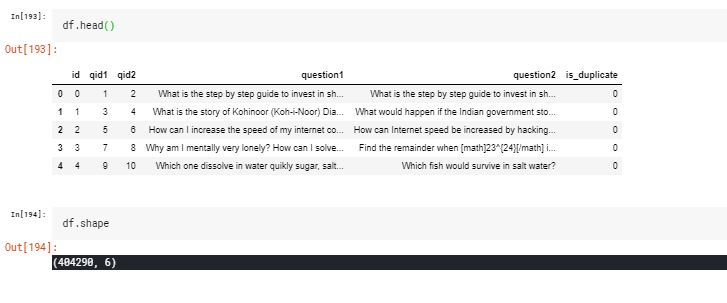


###  Performance Metric
 
* log-loss 
* Binary Confusion Matrix

###  Some Data Analysis

* Distribution of data points among output classes
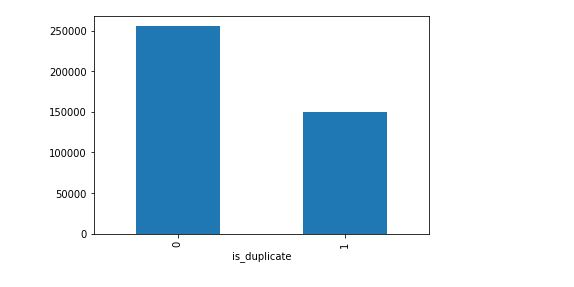

* Number of unique questions

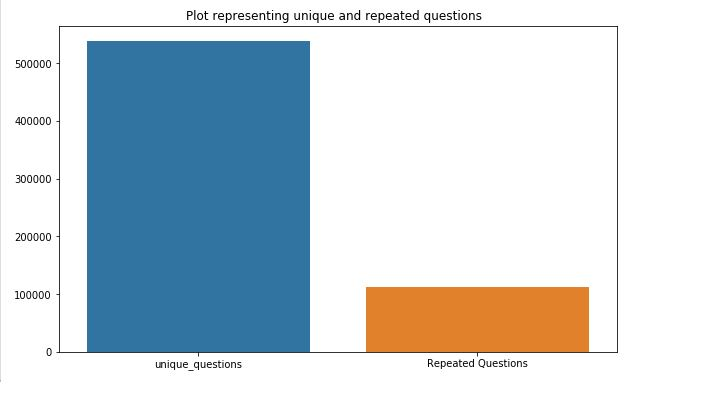

* Wordcloud for similar questions
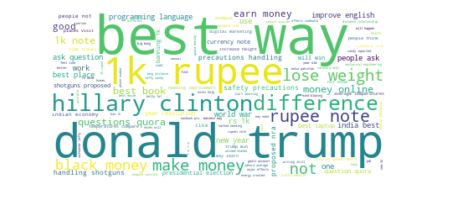

* Wordcloud for dissimilar questions


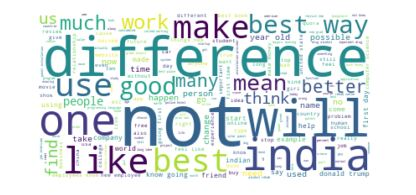

###  Load the data

As it's a high-level dataset, entry-level machines with 8GB RAM will take so much of time for the executions. That's why I switched to Kaggle Kernel for this case study. First I load some basic requirement packages for this case study.

### Creating a SQLite database

I created an SQLite database and wrote records stored in a DataFrame df to a SQL database. And Considered less number of data point randomly like ~100k.

###  Preprocessing

    1. Deduplication of entries
    2. Checking for NULL values
    3. Preprocessing of Text:
         - Removing html tags 
         - Removing Punctuations
         - Performing stemming
         - Removing Stopwords
         - Expanding contractions etc.
         
    4. Removing  empty question rows if any exist
    
    
### Feature Extraction
 
 __Basic Feature Extraction__
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 
 
 
__Advance Feature Extraction__

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :   Ratio of length longest common substring to min length of the token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))
Some Features analysis and visualizations
word_share - We can check from below that it is overlapping a bit, but it is giving some classifiable score for dissimilar questions.

### Some Features analysis and visualizations

- word_share - We can check from below that it is overlaping a bit, but it is giving some classifiable score for disimilar questions.


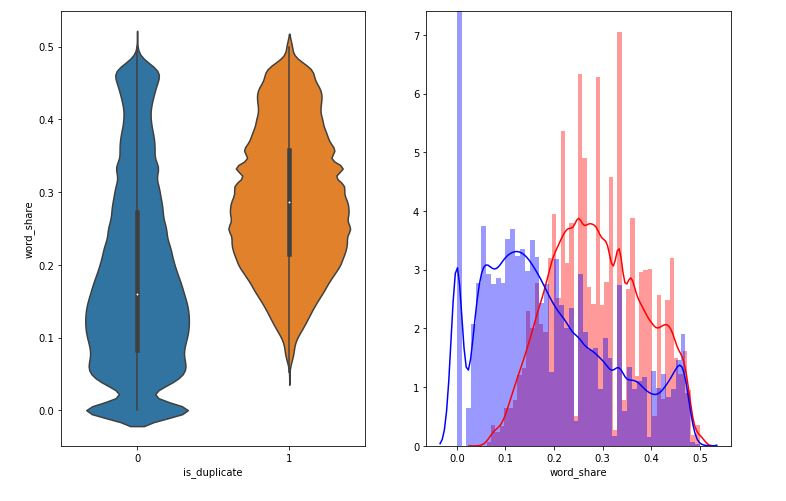

- Word Common - it is almost overlaping.
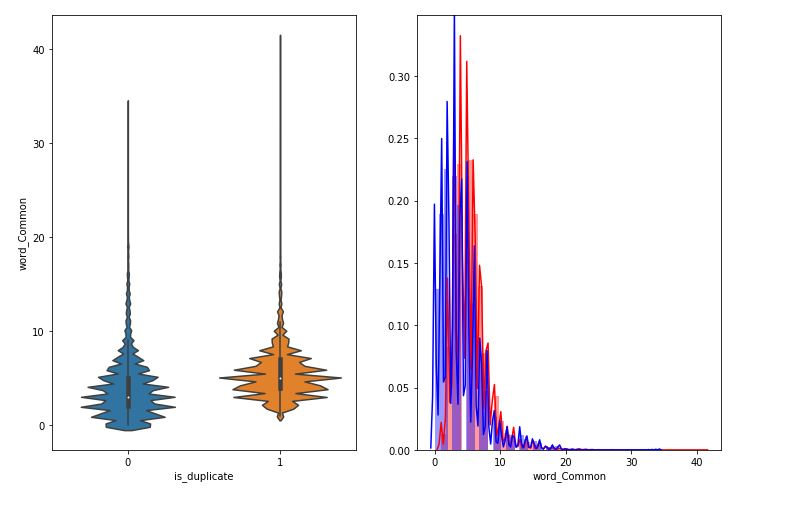

-  Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 
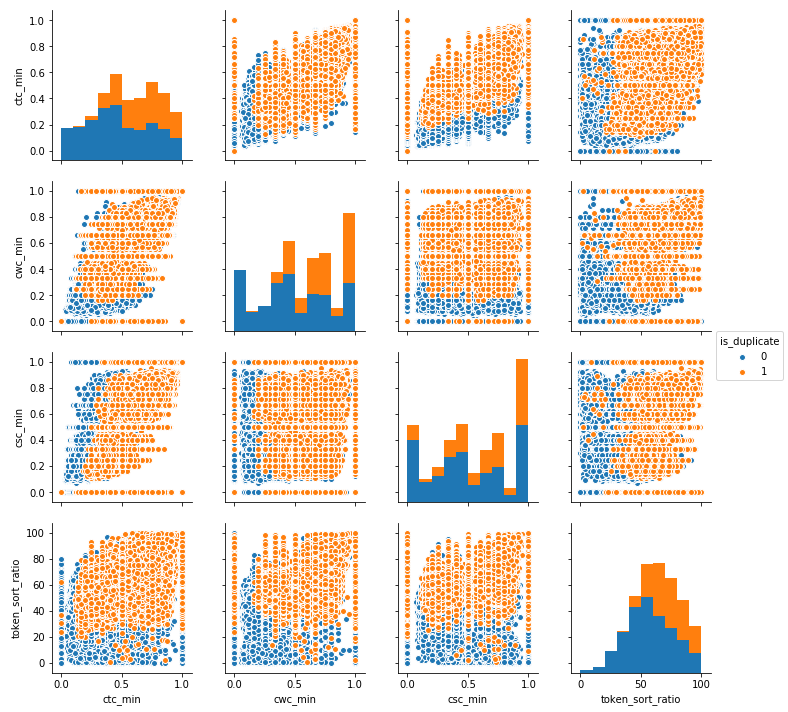


### Machine Learning Models

- Building a random model (Finding worst-case log-loss)
Using a random model to get the upper bound for the log-loss. I want the value of log-loss to be lesser than the log-loss of a random model. Trained a random model to check Worst case log loss and got log loss as ** 0.887019447220453 **.
- Random train test split( 70:30) 
Splited the data in to 70 30 ratio

- Vectorization
Vectorized the data with simple TF-IDF vectors.

- Models
Trained some models and also tuned hyperparameters using Random Search. Hyperparameter tuned XgBoost using RandomSearch to reduce the log-loss. Below are models and their  log loss scores.
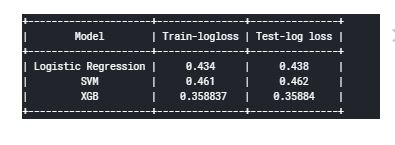
